In [386]:
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geodatasets
import numpy as np
import math
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import os
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


### SA implementation with fixed cooling rate 

In [2]:
"""
Classes
"""
class Cities:
    def __init__(self, csv):
        """
        Class containing all city objects

        Args:
        - Txt file containing cities and coordinates
        """
        # opens file
        with open(csv, "r") as f:
            lines = f.readlines()

        # reads all lines and adds them to a pandas table
        lines = lines[6:-1]
        stripped_lines = [line.strip() for line in lines]
        numbers = [[int(part) for part in line.split()] for line in stripped_lines]
        self.df = pd.DataFrame(numbers, columns=["city", "Longitude", "Latitude"])
        self.df = self.df.iloc[:, 1:]

        # add all city objects
        self.city = []
        for index, row in self.df.iterrows():
            self.city.append(City(row.name, row["Longitude"], row["Latitude"]))

class City:
    """
    Class to create one city object

    Args:
    - City integer
    - X coordinate
    - Y coordinate
    """
    def __init__(self, city, x, y):
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    
class Route:
    """
    Class containing a certain route

    Args:
    - List[A,B] A = 1 B = The amount of cities in the route
    - Cities class, making it possible to link to all city objects
    - Perturbation, specifying the preferred perturbation when initializing
    """
    def __init__(self, list, cities_class, perturbation):
        self.cities = np.random.choice(range(list[1]), size=list[1], replace=False)
        self.route = []
        for i in self.cities:
            self.route.append(cities_class.city[i])
        self.distance = self.calculate_distance()
        self.old_route = []
        self.cities_class = cities_class
        self.perturbation = perturbation
        if self.perturbation == "two_opt":
            self.perturbation = self.two_opt
        elif self.perturbation == "move_single":
            self.perturbation = self.move_single
        else:
            raise ValueError("perturbation does not exist")


    def two_opt(self):
        """
        Performs 2-opt on the current route

        Saves the old route as well
        """
        self.old_route = self.route.copy()
        # choose two indices, ensuring they are non-adjacent
        while True:
            i, j = sorted(np.random.choice(len(self.route), size=2, replace=False))
            if j > i + 1:  
                break

        # reverse the segment between i and j
        self.route[i + 1:j + 1] = reversed(self.route[i + 1:j + 1])

    def move_single(self):
        """
        Moves a single city to another location in the route
        """
        self.old_route = self.route.copy()
        # random index to move
        from_index = np.random.randint(0, len(self.route) - 1)

        # new random location for the element
        to_index = np.random.randint(0, len(self.route) - 1)

        # remove the element at from_index
        element = self.route.pop(from_index)

        # insert the element at the new location
        self.route.insert(to_index, element)

    def calculate_distance(self):
        """
        Calculates the total distance of the route
        """
        distance = 0
        for i in range(len(self.route) - 1):
            distance += self.route[i].get_distance_to(self.route[i+1])
        distance += self.route[-1].get_distance_to(self.route[0])
        self.distance = distance
        return distance
    
    def plot(self):
        """
        plots the route

        From: https://stackoverflow.com/questions/53233228/plot-latitude-longitude-from-csv-in-python-3-6
        """

        geometry = [Point(xy) for xy in zip(self.cities_class.df['Longitude'], self.cities_class.df['Latitude'])]
        gdf = GeoDataFrame(self.cities_class.df, geometry=geometry)   

        world = gpd.read_file(geodatasets.data.naturalearth.land['url'])

        gdf_filtered = gdf[(gdf['Longitude'] > 0) & (gdf['Latitude'] > 0)]
        minx, miny, maxx, maxy = gdf_filtered.total_bounds  

        route_coordinates = [(city.x, city.y) for city in self.route]
        route_coordinates.append((self.route[0].x, self.route[0].y))

        # create a GeoDataFrame for the route as a LineString
        route_line = LineString(route_coordinates)
        route_gdf = gpd.GeoDataFrame(geometry=[route_line])

        # awesome world map 
        ax = world.plot(figsize=(15, 20), color='gray')
        # cities
        gdf_filtered.plot(ax=ax, marker='o', color='black', markersize=20)
        # route
        route_gdf.plot(ax=ax, color='blue', linewidth=1)

        # for i, city in enumerate(cities):
        #     plt.text(city.x, city.y, str(i + 1), fontsize=8, color="black")

        ax.set_xlim(minx - 10, maxx + 5)
        ax.set_ylim(miny - 5, maxy + 10)

        plt.title("Salesman's Route")
        plt.show()
    
    def __repr__(self):
        """
        For printing
        """
        return f"route goes through {len(self.route)} cities"

In [387]:
def load_tour(tour_file):
    """
    Load the optimal tour from the TSP tour file.
    """
    tour = []
    with open(tour_file, "r") as file:
        lines = file.readlines()
        tour_section = False
        for line in lines:
            if "TOUR_SECTION" in line:
                tour_section = True
                continue
            if tour_section:
                city_id = int(line.strip())
                if city_id == -1:
                    break
                tour.append(city_id)
    return tour

In [388]:
class City:
    def __init__(self, city, x, y):
        """
        - city: city integer
        - x coordinate
        - y coordinate
        """
        self.city = city
        self.x = x
        self.y = y
        self.connections = []

    def get_distance_to(self, city):
        """
        Euclidean distance to another city.

        Takes another city object and returns a distance between two cities
        """
        x2, y2 = city.x, city.y
        return np.sqrt((x2 - self.x)**2 + (y2 - self.y)**2)
    
    def connects_to(self, city):
        """
        Connects one city to another by adding it to a list
        """
        self.connections.append(city)

    def __repr__(self):
        """
        For printing
        """
        return f"|City nr. {self.city} at x={self.x}, y={self.y}|"
    


In [256]:
class SimulatedAnnealing1:
    """
    Class for Simulated Annealing

    Args:
    - The amount of cities in the txt file
    - txt file with the cities

    Usage:
    annealing = SimulatedAnnealing(x,x)
    ...
    specify parameters
    ...
    annealing.run(y), where y is the amount of different runs 

    Notes:
    - Set all preferred variables beforehand otherwise it will take default values
    """
    def __init__(self, cities_amount, csv):
        self.init_temp = 1
        self.cooling_rate = .9999  # Fixed step size for cooling
        self.iterations = 100
        self.cities_amount = cities_amount
        self.cities = Cities(csv)
        self.mean = []
        self.sd = []
        self.data = []
        self.final_routes = []
        self.measurement_interval = 1
        self.perturbation = "two_opt"
        self.cooling_method = self.cooling_linear
        self.markov_chain = 1

        self.temp_data = None

    def run(self, runs):
        """
        Runs annealing
        """
        if self.iterations % self.measurement_interval != 0:
            raise ValueError("Iterations divided by measurement interval must be a whole number")

        self.data = np.zeros((runs, int(self.iterations / self.measurement_interval)))
        self.temp_data = np.zeros((runs, int(self.iterations / self.measurement_interval)))

        for i in trange(runs):
            solutions_list = np.zeros(int(self.iterations / self.measurement_interval))
            temperature_list = np.zeros(int(self.iterations / self.measurement_interval))

            route = Route([1, self.cities_amount], self.cities, self.perturbation)
            current_solution = route.calculate_distance()
            solutions_list[0] = current_solution
            current_temp = self.init_temp
            temperature_list[0] = current_temp

            for j in range(1, self.iterations):
                route.perturbation()
                perturbed_solution = route.calculate_distance()

                delta = perturbed_solution - current_solution
                exponent = min(-delta / current_temp, 700)
                probability = math.exp(exponent)

                if delta < 0:
                    current_solution = perturbed_solution
                elif np.random.random() < probability:
                    current_solution = perturbed_solution
                else:
                    route.route = route.old_route.copy()
                    current_solution = route.calculate_distance()

                if j % self.markov_chain == 0:
                    current_temp = self.cooling_method(self.init_temp, self.cooling_rate, j/self.markov_chain)

                if j % self.measurement_interval == 0:
                    solutions_list[int(j / self.measurement_interval)] = current_solution
                    temperature_list[int(j / self.measurement_interval)] = current_temp

            self.final_routes.append(route)
            self.data[i] = solutions_list
            self.temp_data[i] = temperature_list

    @staticmethod
    def cooling_linear(temp_start, cooling_rate, iteration):
        """
        Linear cooling with a fixed step size per iteration.
        """

        new_temp = temp_start - iteration * (1-cooling_rate)
        if new_temp < 0:
            new_temp = 0
        return new_temp

    @staticmethod
    def cooling_exponential(temp_start, cooling_rate, iteration):
        """
        Exponential cooling independent of the number of iterations.
        """
        new_temp = temp_start * (cooling_rate ** iteration)
        if new_temp < 0:
            new_temp = 0
        return new_temp

    @staticmethod
    def cooling_logarithmic(temp_start, cooling_rate, iteration):
        """
        Logarithmic cooling independent of the number of iterations.
        """
        new_temp = temp_start / (1 + cooling_rate * math.log(1 + iteration))
        if new_temp < 0:
            new_temp = 0
        return new_temp

    def set_cooling_method(self, method):
        if method == "linear":
            self.cooling_method = self.cooling_linear
        elif method == "exponential":
            self.cooling_method = self.cooling_exponential
        elif method == "logarithmic":
            self.cooling_method = self.cooling_logarithmic
        else:
            raise ValueError(f"Unknown cooling method: {method}")

    def give_sd_at(self, iteration):
        """
        Returns standard deviation at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.std(self.data[:, iteration])

    def give_mean_at(self, iteration):
        """
        Returns mean at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        return np.mean(self.data[:, iteration])

    def give_all_means(self):
        """
        Returns means over all runs at all iterations in a list 
        """
        return np.mean(self.data, axis=0).tolist()

    def give_all_temps_mean(self):
        return np.mean(self.temp_data, axis=0).tolist()

    def give_all_sd(self):
        """
        Returns standard deviation over all runs at all iterations in a list
        """
        return np.std(self.data, axis=0).tolist()

    def give_ci_at(self, iteration):
        """
        Returns confidence interval at a certain iteration

        IMPORTANT NOTE: make sure that iteration / measurement_interval exists
        """
        iteration = iteration / self.measurement_interval
        std_dev = np.std(self.data[:, iteration])
        n = self.data.shape[0] 
        return (1.96 * std_dev / np.sqrt(n))

    def give_all_ci(self):
        """
        Returns confidence interval over all runs at all iterations in a list
        """
        std_devs = np.std(self.data, axis=0)
        n = self.data.shape[0]
        return (1.96 * std_devs / np.sqrt(n)).tolist()

    def range(self):
        """
        Returns the amount of datapoints 

        Note: useful for plotting
        """
        return int(self.iterations / self.measurement_interval)


### LINEAR

In [264]:
methods = ["linear"] # "exponential", "logarithmic"]

iterations = 500000
markov_values = [1,2,5, 10 ,500]

markov_results = {m: {l: {} for l in markov_values} for m in methods}
markov_temp = {m: {l: {} for l in markov_values} for m in methods}
markov_all_runs_data = {m: {l: {} for l in markov_values} for m in methods}





for method in methods:
    print(f"\n TESTING FOR METHOD {method.upper()} \n ")
    for markov_value in markov_values: 
        print(f"testing for markov chain length {markov_value}")    
        annealing = SimulatedAnnealing1(280, "a280.tsp.txt")
        annealing.set_cooling_method(method)
        annealing.init_temp = 400
        annealing.final_temp = 1
        annealing.iterations = iterations
        annealing.measurement_interval = 10
        annealing.perturbation = "two_opt"
        annealing.cooling_rate = .99
        annealing.markov_chain = markov_value    
        annealing.run(10)
        mean_values = annealing.give_all_means()
        mean_temps = annealing.give_all_temps_mean()
        markov_results[method][markov_value] = mean_values
        markov_temp[method][markov_value] = mean_temps
        markov_all_runs_data[method][markov_value] = annealing.data
        print()



 TESTING FOR METHOD LINEAR 
 
testing for markov chain length 1


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: invalid value encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
100%|██████████| 10/10 [1:04:31<00:00, 387.14s/it]



testing for markov chain length 2


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: invalid value encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
100%|██████████| 10/10 [1:03:59<00:00, 383.91s/it]



testing for markov chain length 5


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: invalid value encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
100%|██████████| 10/10 [1:24:31<00:00, 507.15s/it]



testing for markov chain length 10


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: divide by zero encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
C:\Users\imaan\AppData\Local\Temp\ipykernel_32516\2036752615.py:61: RuntimeWarning: invalid value encountered in scalar divide
  exponent = min(-delta / current_temp, 700)
100%|██████████| 10/10 [53:48<00:00, 322.83s/it]



testing for markov chain length 500


100%|██████████| 10/10 [37:38<00:00, 225.84s/it]

In [265]:

with open("LINEAR_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "wb") as file:
    pickle.dump((markov_results, markov_temp, markov_all_runs_data), file)
    


In [333]:
cities = Cities("a280.tsp.txt") 
optimal_tour = load_tour("a280.opt.tour.txt")
optimal_route = [cities.city[city_id - 1] for city_id in optimal_tour]  # -1 since indexes start at 1 in txt file 

distance = 0
for i in range(len(optimal_route) - 1):
    distance += optimal_route[i].get_distance_to(optimal_route[i + 1])

distance += optimal_route[-1].get_distance_to(optimal_route[0])  # Close the loop

print(f"Optimal route distance: {distance}")
window_size = 100

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


Optimal route distance: 2586.7696475631606


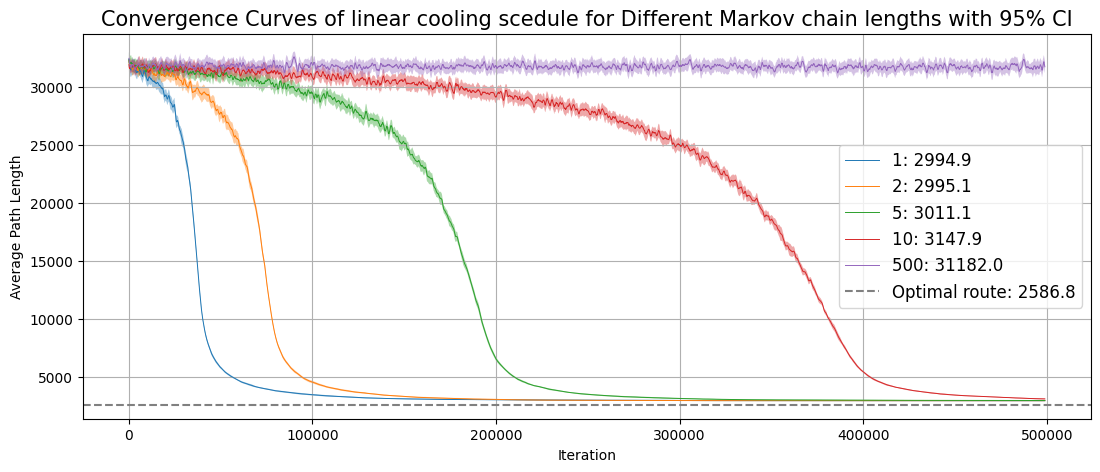

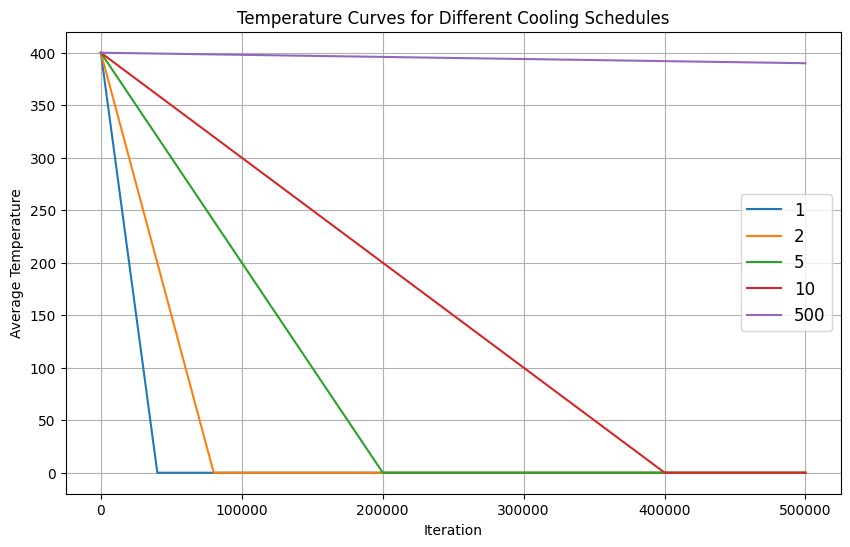

In [384]:
with open("FINAL/LINEAR/LINEAR_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "rb") as file:
        markov_results, markov_temp, markov_all_runs_data = pickle.load(file)
methods = ["linear"]
for method in methods: 
    plt.figure(figsize=((13,5)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values: 
        mean_values = markov_results[method][markov_value]
        mean_values = moving_average(mean_values, window_size)
        
        ci_values = 1.96 * np.std(markov_all_runs_data[method][markov_value], axis=0) / np.sqrt(markov_all_runs_data[method][markov_value].shape[0])
        ci_values = moving_average(ci_values, window_size)[:len(mean_values)]  # Ensure same length
        
        x_axis = x_axis[:len(mean_values)]
        plt.plot(x_axis, mean_values, linewidth = .7, label=f"{markov_value}: {np.min(mean_values):.1f}")
        plt.fill_between(x_axis, mean_values - ci_values, mean_values + ci_values, alpha=0.4)
    plt.axhline(y = distance, linestyle = "--", color = "gray", label = f"Optimal route: {distance:.1f}")
    plt.title(f"Convergence Curves of {method} cooling scedule for Different Markov chain lengths with 95% CI", fontsize = 15)
    plt.xlabel("Iteration")
    plt.ylabel("Average Path Length")
    plt.legend(fontsize = "large")
    plt.grid(True)
    plt.savefig("LINEAR_graph", dpi=300)

    plt.show()

for method in methods: 
    plt.figure(figsize=((10,6)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values: 
        plt.plot(x_axis, markov_temp[method][markov_value], label = f"{markov_value}")
    plt.title("Temperature Curves for Different Cooling Schedules")
    plt.xlabel("Iteration")
    plt.ylabel("Average Temperature")
    plt.legend(fontsize = "large")
    plt.grid(True)
    plt.savefig("LINEAR_temp", dpi=300, bbox_inches='tight')

    plt.show()





### EXPONENTIAL

In [278]:
methods = [ "exponential" ] 

iterations = 500000
markov_values = [1,2,5, 10 ,500]

markov_results = {m: {l: {} for l in markov_values} for m in methods}
markov_temp = {m: {l: {} for l in markov_values} for m in methods}
markov_all_runs_data = {m: {l: {} for l in markov_values} for m in methods}



for method in methods:
    print(f"\n TESTING FOR METHOD {method.upper()} \n ")
    for markov_value in markov_values: 
        print(f"testing for markov chain length {markov_value}")    
        annealing = SimulatedAnnealing1(280, "a280.tsp.txt")
        annealing.set_cooling_method(method)
        annealing.init_temp = 400
        annealing.final_temp = 1
        annealing.iterations = iterations
        annealing.measurement_interval = 10
        annealing.perturbation = "two_opt"
        annealing.cooling_rate = .999
        annealing.markov_chain = markov_value    
        annealing.run(10)
        mean_values = annealing.give_all_means()
        mean_temps = annealing.give_all_temps_mean()
        markov_results[method][markov_value] = mean_values
        markov_temp[method][markov_value] = mean_temps
        markov_all_runs_data[method][markov_value] = annealing.data
        print()



 TESTING FOR METHOD EXPONENTIAL 
 
testing for markov chain length 1


100%|██████████| 10/10 [1:35:11<00:00, 571.15s/it]



testing for markov chain length 2


100%|██████████| 10/10 [1:04:09<00:00, 384.92s/it]



testing for markov chain length 5


100%|██████████| 10/10 [1:04:38<00:00, 387.83s/it]



testing for markov chain length 10


100%|██████████| 10/10 [1:03:19<00:00, 379.92s/it]



testing for markov chain length 500


100%|██████████| 10/10 [38:53<00:00, 233.39s/it]

In [279]:

with open("EXPO_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "wb") as file:
    pickle.dump((markov_results, markov_temp, markov_all_runs_data), file)
    


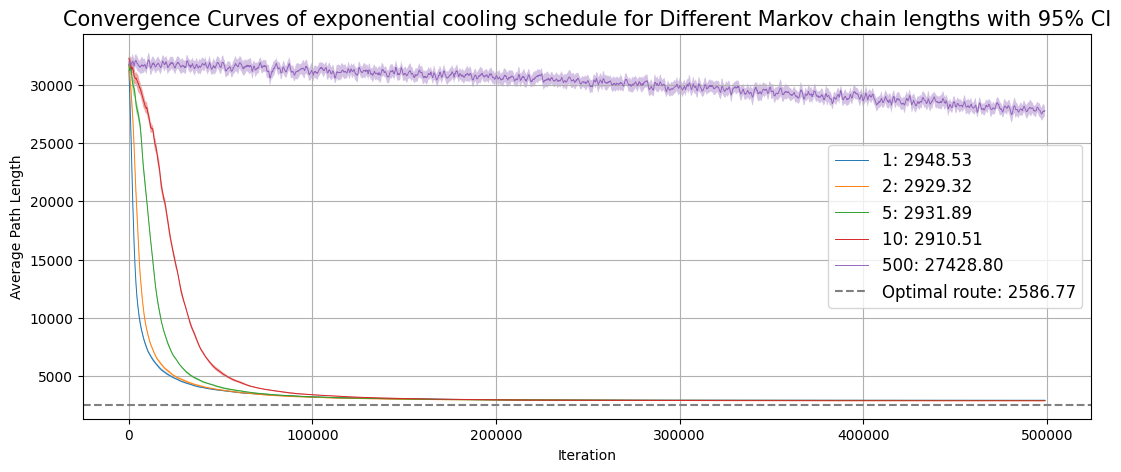

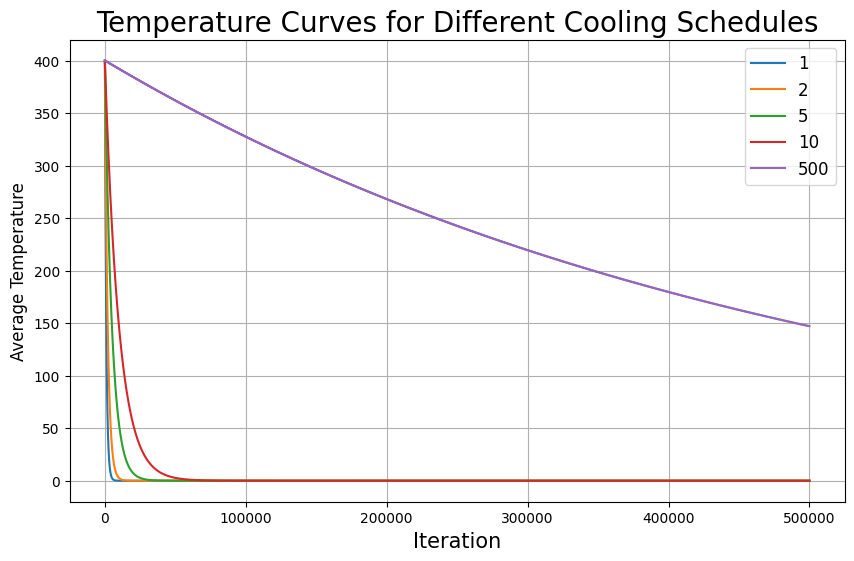

In [381]:
with open("FINAL/EXPO/EXPO_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "rb") as file:
        markov_results, markov_temp, markov_all_runs_data = pickle.load(file)

methods = ["exponential"]



for method in methods:
    plt.figure(figsize=((13,5)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values:
        mean_values = markov_results[method][markov_value]
        mean_values = moving_average(mean_values, window_size)
        
        ci_values = 1.96 * np.std(markov_all_runs_data[method][markov_value], axis=0) / np.sqrt(markov_all_runs_data[method][markov_value].shape[0])
        ci_values = moving_average(ci_values, window_size)[:len(mean_values)]  # Ensure same length
        
        x_axis = x_axis[:len(mean_values)]
        plt.plot(x_axis, mean_values, linewidth = .7, label=f"{markov_value}: {np.min(mean_values):.2f}")
        plt.fill_between(x_axis, mean_values - ci_values, mean_values + ci_values, alpha=0.4)
    plt.axhline(y=distance, linestyle="--", color="gray", label=f"Optimal route: {distance:.2f}")
    plt.title(f"Convergence Curves of {method} cooling schedule for Different Markov chain lengths with 95% CI", fontsize = 15)
    plt.xlabel("Iteration")
    plt.ylabel("Average Path Length")
    plt.legend(fontsize = "large", loc = 'center right')
    plt.grid(True)
    
    plt.savefig("EXPO_graph", dpi=300)
    plt.show()


for method in methods: 
    plt.figure(figsize=((10,6)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values: 
        plt.plot(x_axis, markov_temp[method][markov_value], label=f"{markov_value}")
    plt.title("Temperature Curves for Different Cooling Schedules", fontsize = 20)
    plt.xlabel("Iteration", fontsize = 15)
    plt.ylabel("Average Temperature", fontsize = "large")
    plt.legend(fontsize = "large")
    plt.grid(True)
    plt.savefig("EXPO_temp", dpi=300)
    plt.show()




   

LOGARITHMIC 

In [283]:
methods = [ "logarithmic"]

iterations = 500000
markov_values = [1,2,5, 10 ,500]

markov_results = {m: {l: {} for l in markov_values} for m in methods}
markov_temp = {m: {l: {} for l in markov_values} for m in methods}
markov_all_runs_data = {m: {l: {} for l in markov_values} for m in methods}



for method in methods:
    print(f"\n TESTING FOR METHOD {method.upper()} \n ")
    for markov_value in markov_values: 
        print(f"testing for markov chain length {markov_value}")    
        annealing = SimulatedAnnealing1(280, "a280.tsp.txt")
        annealing.set_cooling_method(method)
        annealing.init_temp = 400
        annealing.final_temp = 1
        annealing.iterations = iterations
        annealing.measurement_interval = 10
        annealing.perturbation = "two_opt"
        annealing.cooling_rate = .999 
        annealing.markov_chain = markov_value    
        annealing.run(10)
        mean_values = annealing.give_all_means()
        mean_temps = annealing.give_all_temps_mean()
        markov_results[method][markov_value] = mean_values
        markov_temp[method][markov_value] = mean_temps
        markov_all_runs_data[method][markov_value] = annealing.data
        print()



 TESTING FOR METHOD LOGARITHMIC 
 
testing for markov chain length 1


100%|██████████| 10/10 [58:04<00:00, 348.41s/it]



testing for markov chain length 2


100%|██████████| 10/10 [58:37<00:00, 351.72s/it]



testing for markov chain length 5


100%|██████████| 10/10 [57:32<00:00, 345.29s/it]



testing for markov chain length 10


100%|██████████| 10/10 [56:10<00:00, 337.02s/it]



testing for markov chain length 500


100%|██████████| 10/10 [51:28<00:00, 308.86s/it]

In [284]:

with open("LOG_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "wb") as file:
    pickle.dump((markov_results, markov_temp, markov_all_runs_data), file)
    


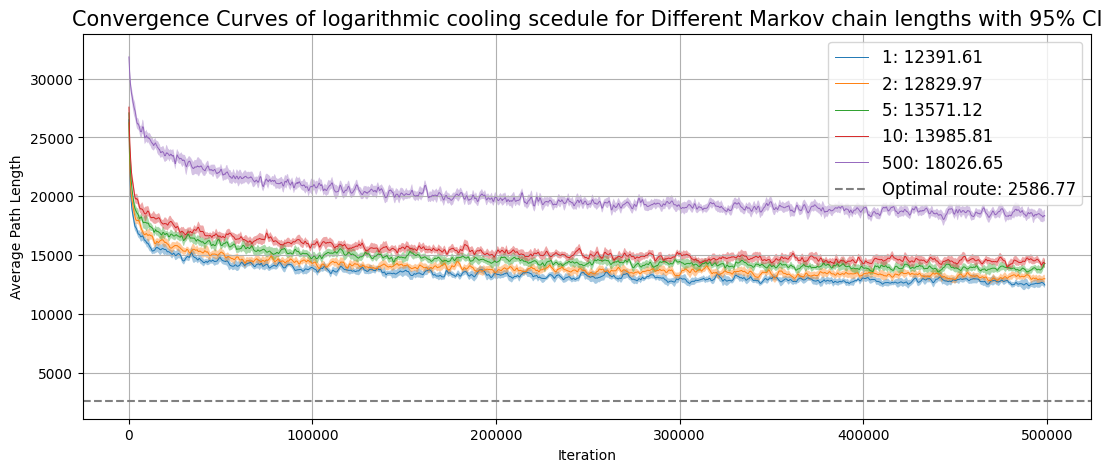

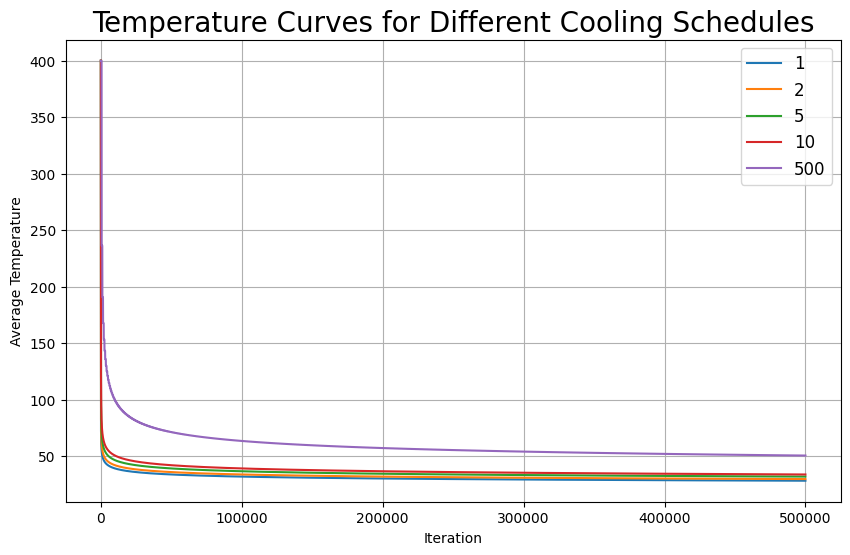

In [379]:
with open("FINAL/LOG/LOG_MARKOV_NO_ADJUST_results_1mil_cooling_with_annealing.pkl", "rb") as file:
        markov_results, markov_temp, markov_all_runs_data = pickle.load(file)
methods = [ "logarithmic"]


for method in methods: 
    plt.figure(figsize=((13,5)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values: 
        mean_values = markov_results[method][markov_value]
        mean_values = moving_average(mean_values, window_size)
        
        ci_values = 1.96 * np.std(markov_all_runs_data[method][markov_value], axis=0) / np.sqrt(markov_all_runs_data[method][markov_value].shape[0])
        ci_values = moving_average(ci_values, window_size)[:len(mean_values)]  # Ensure same length
        
        x_axis = x_axis[:len(mean_values)]
        plt.plot(x_axis,  mean_values, label=f"{markov_value}: {np.min(mean_values):.2f}", linewidth = .7)
        plt.fill_between(x_axis, mean_values - ci_values, mean_values + ci_values, alpha=0.4)
    plt.axhline(y = distance, linestyle = "--", color = "gray", label = f"Optimal route: {distance:.2f}")
    plt.title(f"Convergence Curves of {method} cooling scedule for Different Markov chain lengths with 95% CI", fontsize = 15)
    plt.xlabel("Iteration")
    plt.ylabel("Average Path Length")
    plt.legend(fontsize = "large", loc = 'upper right')
    plt.grid(True)
    plt.savefig("LOG_graph", dpi=300)

    plt.show()

for method in methods: 
    plt.figure(figsize=((10,6)))
    x_axis = np.arange(0, int(iterations), 10)  # since measurement_interval=10
    for markov_value in markov_values: 
        plt.plot(x_axis, markov_temp[method][markov_value], label = f"{markov_value}")
    plt.title("Temperature Curves for Different Cooling Schedules", fontsize = 20)
    plt.xlabel("Iteration")
    plt.ylabel("Average Temperature")
    plt.legend(fontsize = "large")
    plt.grid(True)
    plt.savefig("LOG_temp", dpi=300)

    plt.show()

